#**Домашнее задание №2:  llmtf task**

###**Цель задания**


Реализовать некоторую задачу с использованием фреймворка llmtf и оценить с ее помощью 2 модели LLM. Мы рассмотрим RuadaptQwen2.5-1.5B-instruct и Vikhr-Qwen-2.5-1.5B-Instruct.





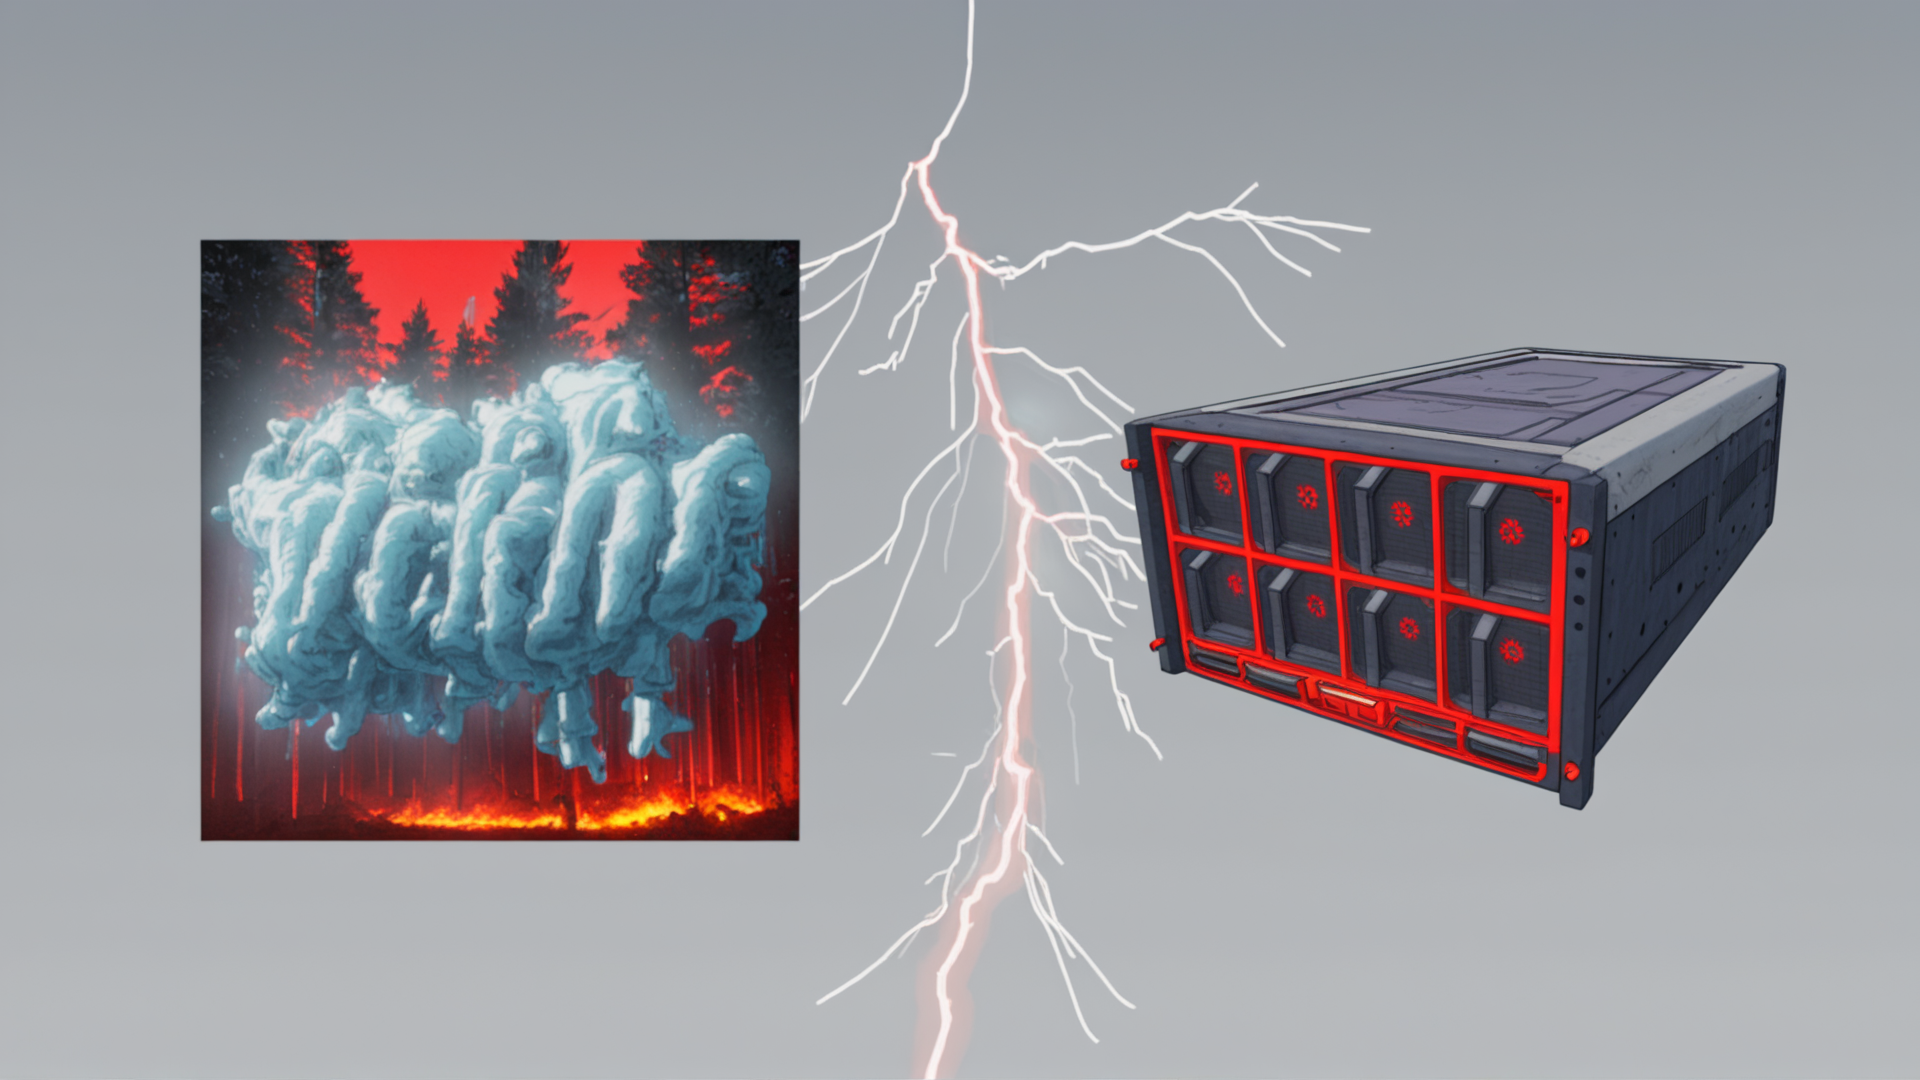

Возьмем датасет *ai-forever/MERA* (сабсет "*rcb*") с полями:
*   instruction: инструкция к задаче,
*   inputs: входной текст, из которого надо получить ответ,
*   outputs: истинное значение (в нашем случае – метка: 1, 2 или 3),
*   meta: доп. информация.

*Пример из карточки:*
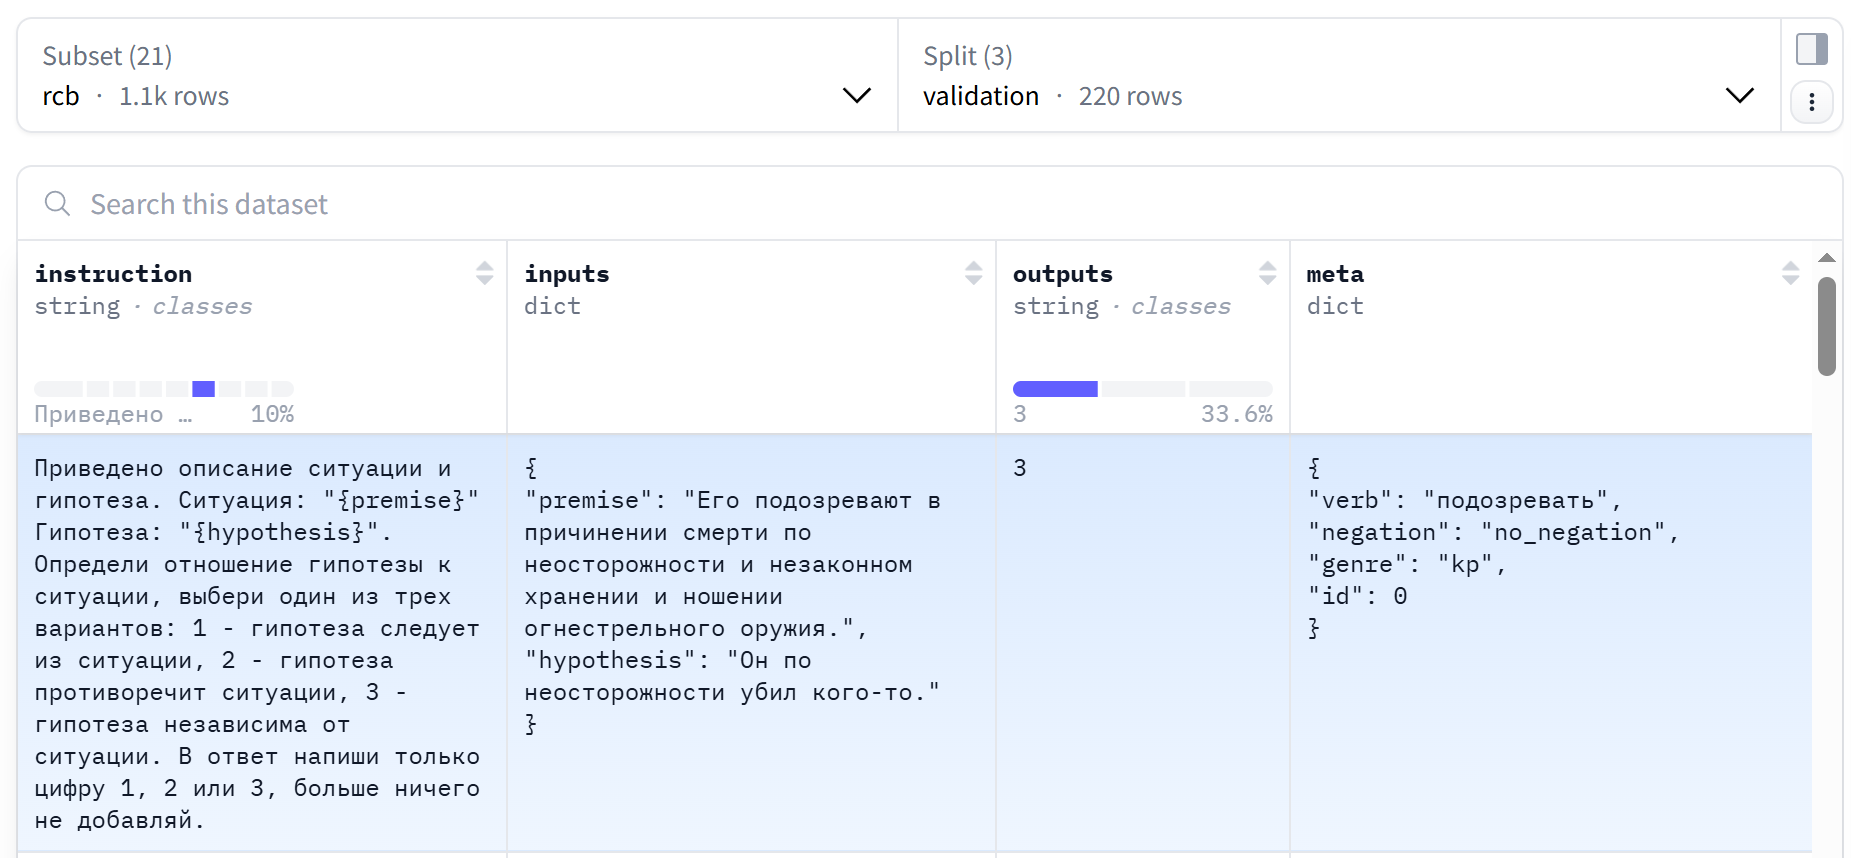

###Задача
Сформировать промпт, объединяя instruction и inputs, чтобы модель сгенерировала ответ, соответствующий одному из трех вариантов (1, 2 или 3): так, модель обязана генерировать ответ в структурированном виде, который легко парсить. Далее с помощью встроенной функции оценки вычислить метрику (в данном случае accuracy).

###Код
Для начала выполняем установку нужных библиотек и клонируем репозиторий:

In [1]:
!nvidia-smi #наличие GPU

!pip install transformers
!pip install datasets
!pip install rouge-score
!pip install pymorphy3
!pip install peft

!git clone https://github.com/RefalMachine/llmtf_open
%cd llmtf_open

Sun Mar 16 18:58:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Определим класс задачи. Класс GenerativeTask наследуется от SimpleFewShotHFTask и реализует следующие методы:



*   dataset_args: загружает датасет MERA (сабсет "rcb").
*   create_messages: формирует промпт, объединяя поля instruction и inputs.
*   evaluate: сравнивает сгенерированный ответ с истинным значением. Если ответ не является списком, то производится прямое сравнение, и возвращается метрика accuracy.
*   aggregation: задает агрегаторы для метрик (accuracy, precision, recall, f1).
*   test_split_name и prompt_split_name: возвращают "validation", что соответствует рассматриваемому ключу датасета.








Отмечу, что функция *compute_ner_f1* изначально предназначалась для оценки задач NER, но в данном случае используется метод evaluate, который сравнивает сгенерированный ответ с истинным значением (если ответ не является списком, как в нашем случае, производится прямое сравнение).

In [3]:
import json
import numpy as np
from typing import Dict, List
from llmtf.base import SimpleFewShotHFTask

def compute_ner_f1(true_entities: List[Dict], pred_entities: List[Dict]) -> Dict:
    """
    Вычисляем Precision, Recall и F1 для извлечения сущностей.
    Сущность считается корректно извлеченной, если совпадают и текст, и метка.
    """
    true_set = {(ent['entity'], ent['label']) for ent in true_entities}
    pred_set = {(ent['entity'], ent['label']) for ent in pred_entities}

    precision = len(true_set & pred_set) / len(pred_set) if pred_set else 0.0
    recall = len(true_set & pred_set) / len(true_set) if true_set else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0.0
    return {"precision": precision, "recall": recall, "f1": f1}

class GenerativeTask(SimpleFewShotHFTask):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.method = 'generate'
        self._max_new_tokens = 128
        self.dataset_name = 'MERA_rcb'

    @classmethod
    def name(cls):
        return 'custom/Generative_MERA'

    def dataset_args(self) -> Dict:
        return {"path": "ai-forever/MERA", "name": "rcb"}

    def aggregation(self) -> Dict:
        return {"accuracy": np.mean, "precision": np.mean, "recall": np.mean, "f1": np.mean}

    def evaluate(self, sample, y_pred) -> Dict:
        # попытка распарсить предсказание
        try:
            pred = json.loads(y_pred)
        except Exception as e:
            pred = y_pred.strip()
        # попытка распарсить истинное значение
        try:
            if isinstance(sample["outputs"], str):
                true_val = json.loads(sample["outputs"])
            else:
                true_val = sample["outputs"]
        except Exception as e:
            true_val = sample["outputs"]

        # если true_val и pred не являются списками, сравниваем их напрямую (как строки)
        if not isinstance(true_val, list) and not isinstance(pred, list):
            accuracy = 1.0 if str(true_val).strip() == str(pred).strip() else 0.0
            return {"accuracy": accuracy}
        else:
            # если это списки (например, для NER) то вычисляем метрики
            if not isinstance(pred, list):
                pred = []
            if not isinstance(true_val, list):
                true_val = []
            metrics = compute_ner_f1(true_val, pred)
            metrics.setdefault("precision", 0.0)
            metrics.setdefault("recall", 0.0)
            metrics.setdefault("f1", 0.0)
            return metrics

    def test_split_name(self) -> str:
        return "validation"

    def prompt_split_name(self) -> str:
        return "validation"

    def create_messages(self, sample, with_answer=None) -> List[Dict]:
        #формируем промпт для модели
        instruction = sample["instruction"]
        inputs = sample["inputs"]
        prompt = f"{instruction}\n{inputs}"
        return [{"role": "user", "content": prompt}]

task = GenerativeTask()

Загружаем 2 модели с помощью класса HFModel из фреймворка llmtf (без квантования). Ставим максимум 1 токен, т.к. нам требуется сгенерировать лишь одну цифру.

In [20]:
from llmtf.model import HFModel

#RuadaptQwen2.5-1.5B-instruct
model1 = HFModel(attn_implementation='sdpa', device_map='cuda')
model1.from_pretrained('RefalMachine/RuadaptQwen2.5-1.5B-instruct')
model1.generation_config.max_new_tokens = 1
model1.generation_config.repetition_penalty = 1.0
model1.generation_config.do_sample = True
model1.generation_config.temperature = 0.01
model1.generation_config.top_k = 3
model1.generation_config.top_p = 0.6

#Vikhr-Qwen-2.5-1.5B-Instruct
model2 = HFModel(attn_implementation='sdpa', device_map='cuda')
model2.from_pretrained('Vikhrmodels/Vikhr-Qwen-2.5-1.5B-Instruct')
model2.generation_config.max_new_tokens = 1
model2.generation_config.do_sample = True
model2.generation_config.temperature = 0.01
model2.generation_config.top_k = 3
model2.generation_config.top_p = 0.6

INFO: 2025-03-16 19:31:27,609: llmtf.base.hfmodel: Set eos_token_id in generation_config to [145111]
INFO:llmtf.base.hfmodel:Set eos_token_id in generation_config to [145111]
INFO: 2025-03-16 19:31:27,613: llmtf.base.hfmodel: Model id: RefalMachine/RuadaptQwen2.5-1.5B-instruct
INFO:llmtf.base.hfmodel:Model id: RefalMachine/RuadaptQwen2.5-1.5B-instruct
INFO: 2025-03-16 19:31:27,614: llmtf.base.hfmodel: Leading space: False
INFO:llmtf.base.hfmodel:Leading space: False
INFO: 2025-03-16 19:31:30,594: llmtf.base.hfmodel: Set eos_token_id in generation_config to [151645]
INFO:llmtf.base.hfmodel:Set eos_token_id in generation_config to [151645]
INFO: 2025-03-16 19:31:30,598: llmtf.base.hfmodel: Model id: Vikhrmodels/Vikhr-Qwen-2.5-1.5B-Instruct
INFO:llmtf.base.hfmodel:Model id: Vikhrmodels/Vikhr-Qwen-2.5-1.5B-Instruct
INFO: 2025-03-16 19:31:30,600: llmtf.base.hfmodel: Leading space: False
INFO:llmtf.base.hfmodel:Leading space: False


FORCES SYSTEM PROMPT AT START=<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>



Оцениваем модели. Оценка производится с помощью класса Evaluator из фреймворка. Результаты сохраняются в соответствующих директориях, а затем выводятся итоговые JSON-файлы с метриками.

In [21]:
from llmtf.evaluator import Evaluator
evaluator = Evaluator()

# оценка RuadaptQwen2.5-1.5B-instruct
evaluator.evaluate_dataset(
    task=task,
    model=model1,
    output_dir='./mera_model1',
    max_len=1024,
    few_shot_count=0,
    generation_config=None,
    batch_size=1,
    max_sample_per_dataset=100  # оцениваем первые 100 примеров
)

# оценка Vikhr-Qwen-2.5-1.5B-Instruct
evaluator.evaluate_dataset(
    task=task,
    model=model2,
    output_dir='./mera_model2',
    max_len=1024,
    few_shot_count=0,
    generation_config=None,
    batch_size=1,
    max_sample_per_dataset=100 # оцениваем первые 100 примеров
)

INFO: 2025-03-16 19:31:30,612: llmtf.base.hfmodel: Updated generation_config.eos_token_id: [145111]
INFO:llmtf.base.hfmodel:Updated generation_config.eos_token_id: [145111]
INFO: 2025-03-16 19:31:30,614: llmtf.base.hfmodel: Updated generation_config.stop_strings: ['<|im_end|>']
INFO:llmtf.base.hfmodel:Updated generation_config.stop_strings: ['<|im_end|>']
100%|██████████| 100/100 [00:00<00:00, 1021.72it/s]
INFO: 2025-03-16 19:31:31,532: llmtf.base.custom/Generative_MERA: Loading Dataset: 0.92s
INFO:llmtf.base.custom/Generative_MERA:Loading Dataset: 0.92s
100%|██████████| 100/100 [00:19<00:00,  5.17it/s]
INFO: 2025-03-16 19:31:50,865: llmtf.base.custom/Generative_MERA: Processing Dataset: 19.33s
INFO:llmtf.base.custom/Generative_MERA:Processing Dataset: 19.33s
INFO: 2025-03-16 19:31:50,867: llmtf.base.custom/Generative_MERA: Results for custom/Generative_MERA:
INFO:llmtf.base.custom/Generative_MERA:Results for custom/Generative_MERA:
INFO: 2025-03-16 19:31:50,870: llmtf.base.custom/Gene

In [23]:
# оценка RuadaptQwen2.5-1.5B-instruct
!ls ./mera_model1/
!cat ./mera_model1/custom_Generative_MERA_total.jsonl

# оценка Vikhr-Qwen-2.5-1.5B-Instruct
!ls ./mera_model2/
!cat ./mera_model2/custom_Generative_MERA_total.jsonl

custom_Generative_MERA.jsonl	     custom_Generative_MERA_total.jsonl
custom_Generative_MERA_params.jsonl
{
    "task_name": "custom/Generative_MERA",
    "results": {
        "accuracy": 0.36
    },
    "leaderboard_result": 0.36
}
custom_Generative_MERA.jsonl	     custom_Generative_MERA_total.jsonl
custom_Generative_MERA_params.jsonl
{
    "task_name": "custom/Generative_MERA",
    "results": {
        "accuracy": 0.21
    },
    "leaderboard_result": 0.21
}


###Вывод
В результате оценки моделей по задаче выбора ответа были получены следующие метрики:

*   RuadaptQwen2.5-1.5B-instruct: **accuracy = 0.36**
*   Vikhr-Qwen-2.5-1.5B-Instruct: **accuracy = 0.21**

Так, RuadaptQwen2.5-1.5B-instruct демонстрирует заметно более высокую точность в генерации требуемого ответа по сравнению с моделью Vikhr-Qwen-2.5-1.5B-Instruct. Однако общие показатели точности остаются невысокими, что свидетельствует о необходимости дальнейшей настройки промптов (в данном случае мы использовали промпты из предоставленного датасета); может быть, стоит взять более мощные модельки с большим число параметров.

В целом, пайплайн оценки был успешно реализован. Цель достигнута!